In [10]:
%reload_ext autoreload
%autoreload 2

import json
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
from lib import utils


plt.rcParams['font.family'] = 'times new roman'
plt.rcParams['font.size'] = 20

In [5]:
%run -i lib\load_data

Meta data is created.
Main data is loaded successfully.


In [6]:
%run -i lib\cluster_analysis

Number of participants who fail consistency check: 36
Worker IDs to be excluded: [434924, 434925, 434938, 434939, 434948, 434951, 434956, 434965, 434970, 434973, 434975, 434987, 434991, 435006, 435007, 435012, 435014, 435023, 435025, 435034, 435037, 435044, 435050, 435051, 435061, 435071, 435078, 435082, 435085, 435088, 435091, 435094, 435102, 435109, 435125, 435126]
Consistency check finished.
Number of subjects in each cluster:
K-means [104  57]
GMM [99 62]


In [7]:
df = pd.read_csv('valid_sequence_data.csv',index_col=0)

C:\Users\zarkwang\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\zarkwang\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\zarkwang\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\zarkwang\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

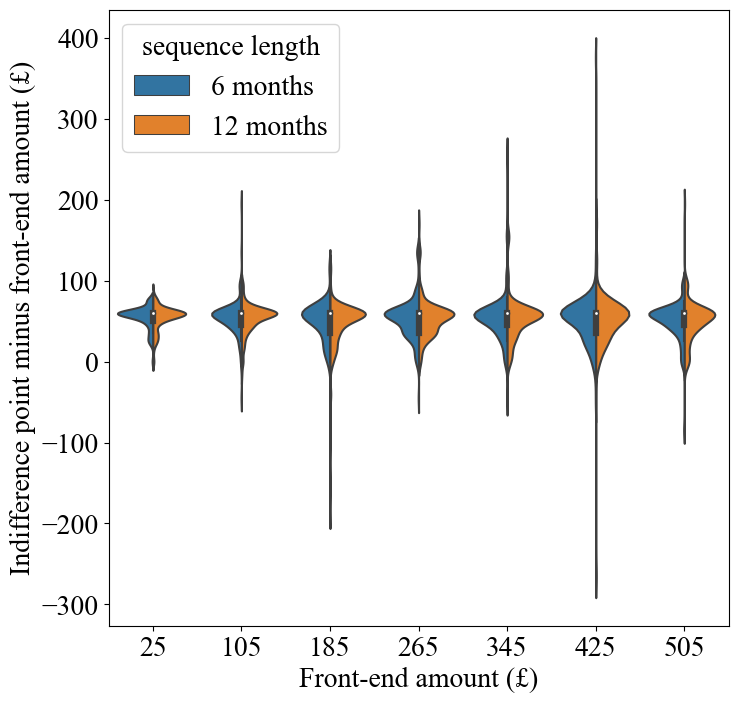

In [15]:
# Plot: check outliers
df_plot = df.groupby(['seq_length','front_amount'])['indiff_point'].mean().to_frame().reset_index()
seq_length_list = df_plot['seq_length'].unique()
front_amount_list = df_plot['front_amount'].unique()

plt.figure(figsize=(8, 8))
# for t in seq_length_list:
#     tab_plot = df[df['seq_length'] == t]
#     plt.scatter(tab_plot['front_amount'],tab_plot['value_surplus'],label=t,alpha=0.75,s=80)

sns.violinplot(x='front_amount', y='value_surplus', hue='seq_length', data=df, split=True)

# Add title and labels
plt.xlabel('Front-end amount (£)')
plt.ylabel('Indifference point minus front-end amount (£)')
# plt.xticks(front_amount_list)
plt.legend(loc=2,title='sequence length')
plt.show()


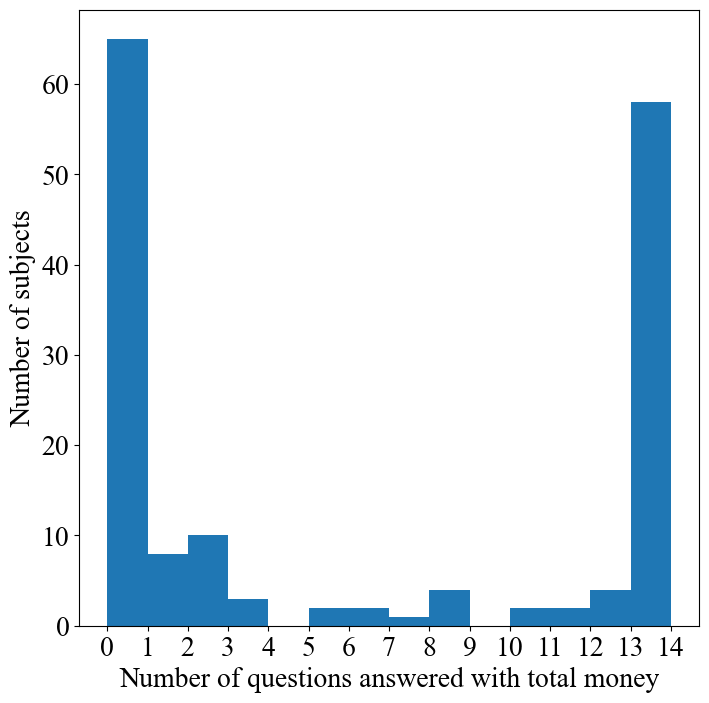

In [13]:
df['total_money_heuristic'] = df['value_surplus'] == 60
plt.figure(figsize=(8,8))
plt.hist(df.groupby('worker_id')['total_money_heuristic'].sum(),bins=14)
plt.xticks(np.arange(15))
plt.ylabel('Number of subjects')
plt.xlabel('Number of questions answered with total money')
plt.show()

Text(0.5, 0, 'front-end amount (£)')

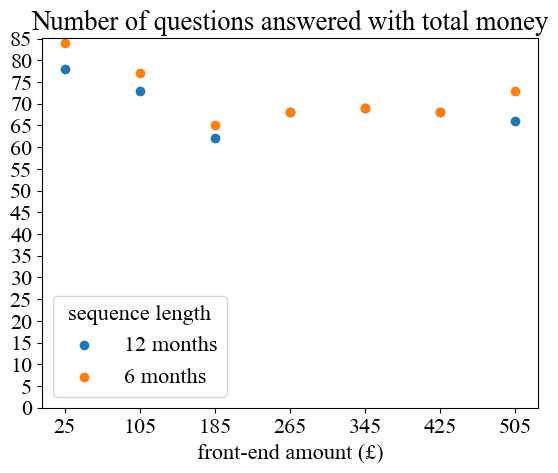

In [10]:
df_plot = df.groupby(['seq_length','front_amount'])['total_money_heuristic'].sum().to_frame().reset_index()
front_amount_list = df_plot['front_amount'].unique()

for t in seq_length_list:
    tab_plot = df_plot[df_plot['seq_length'] == t]
    plt.scatter(tab_plot['front_amount'],tab_plot['total_money_heuristic'],label=t)

plt.title('Number of questions answered with total money')
plt.legend(loc='best',title='sequence length')
plt.xticks(front_amount_list)
plt.yticks(np.arange(0,90,step=5))
plt.xlabel('front-end amount (£)')

Text(0.5, 0, 'front-end amount (£)')

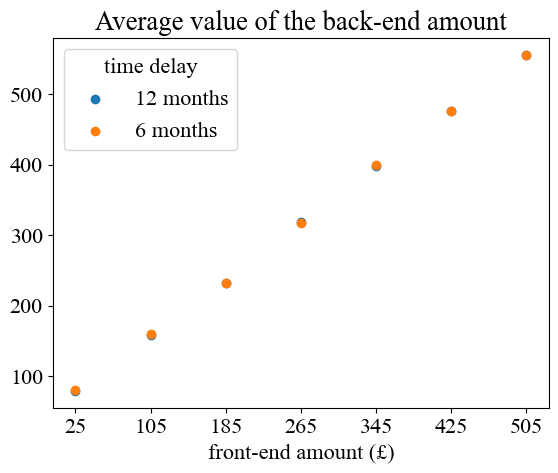

In [11]:
df_plot = df.groupby(['seq_length','front_amount'])['indiff_point'].mean().to_frame().reset_index()
front_amount_list = df_plot['front_amount'].unique()

for t in seq_length_list:
    tab_plot = df_plot[df_plot['seq_length'] == t]
    plt.scatter(tab_plot['front_amount'],tab_plot['indiff_point'],label=t)

plt.title('Average value of the back-end amount')
plt.legend(loc='best',title='time delay')
plt.xticks(front_amount_list)
plt.xlabel('front-end amount (£)')

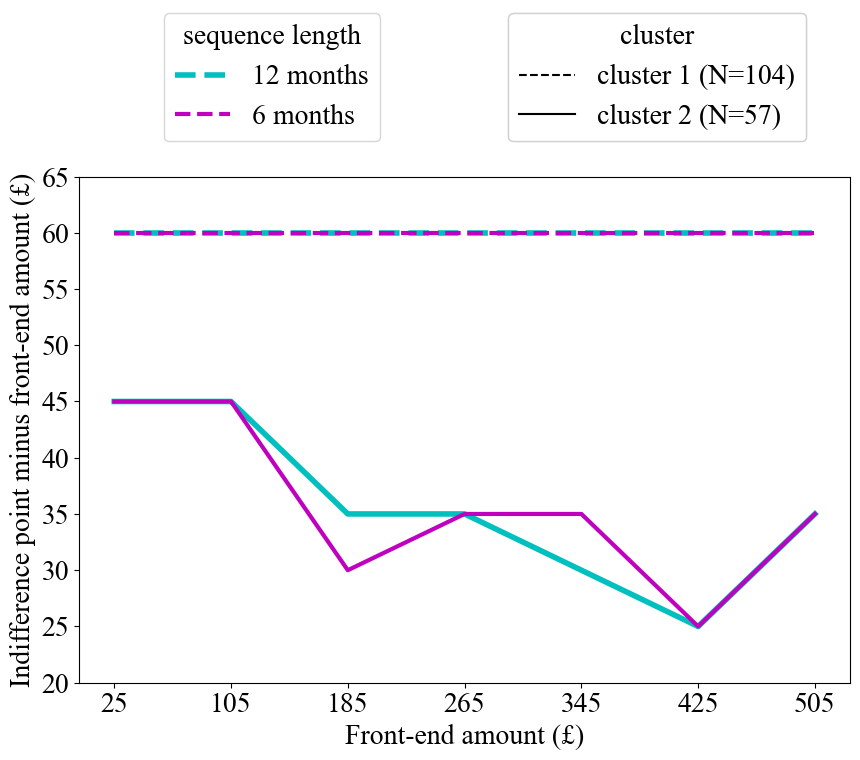

In [22]:
utils.median_plot(df,label_name='label_kmeans')

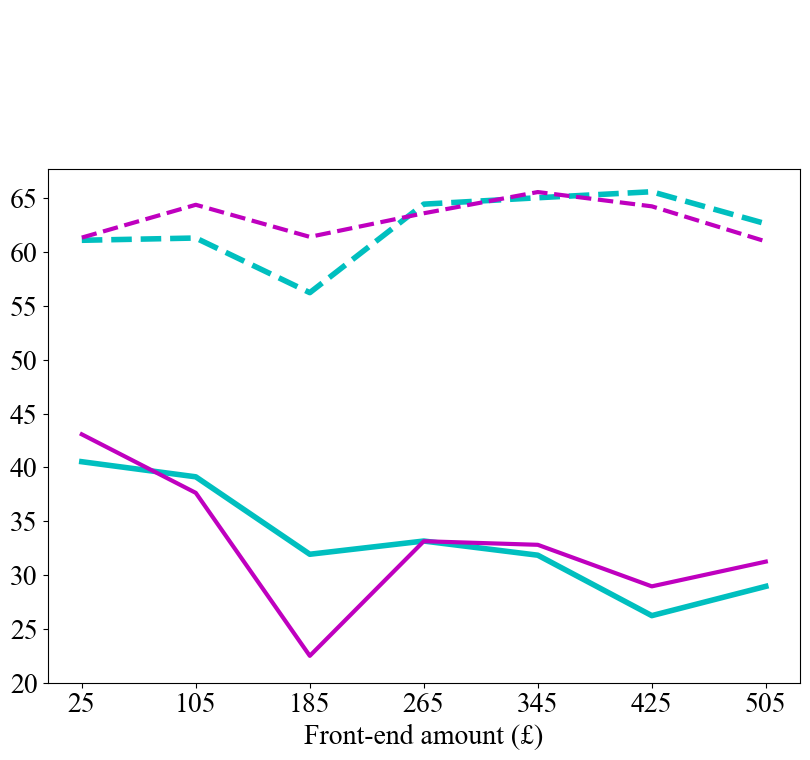

In [25]:
utils.median_plot(df,label_name='label_kmeans',method='mean',hide_axis=True)

In [14]:
print('Mean response time, split by whether using total money heuristic')
print(df.groupby('total_money_heuristic')['response_time_enter'].mean())
print(stats.ttest_ind(df['response_time_enter'][df['total_money_heuristic'] == 0],
                df['response_time_enter'][df['total_money_heuristic'] == 1]))
print('')
print('Ratio of answers using total money heuristic, split by k-means clustered label')
print(df.groupby('label_kmeans')['total_money_heuristic'].mean())
print(stats.ttest_ind(df['total_money_heuristic'][df['label_kmeans'] == 0],
                df['total_money_heuristic'][df['label_kmeans'] == 1]))
print('')
print('Ratio of answers using total money heuristic, split by GMM clustered label')
print(df.groupby('label_gmm')['total_money_heuristic'].mean())
print(stats.ttest_ind(df['total_money_heuristic'][df['label_gmm'] == 0],
                df['total_money_heuristic'][df['label_gmm'] == 1]))
print('')
print('mean response time, split by GMM clustered label')
print(df.groupby('label_gmm')['response_time_enter'].mean())
print(stats.ttest_ind(df['response_time_enter'][df['label_gmm'] == 0],
                df['response_time_enter'][df['label_gmm'] == 1]))

Mean response time, split by whether using total money heuristic
total_money_heuristic
False    10881.589258
True      9283.758097
Name: response_time_enter, dtype: float64
TtestResult(statistic=4.1769308765333175, pvalue=3.067287756424532e-05, df=2252.0)

Ratio of answers using total money heuristic, split by k-means clustered label
label_kmeans
0    0.631181
1    0.086466
Name: total_money_heuristic, dtype: float64
TtestResult(statistic=29.272349061422467, pvalue=6.704994982502427e-160, df=2252.0)

Ratio of answers using total money heuristic, split by GMM clustered label
label_gmm
0    0.190476
1    0.834101
Name: total_money_heuristic, dtype: float64
TtestResult(statistic=-38.62090047518177, pvalue=7.881981399504056e-251, df=2252.0)

mean response time, split by GMM clustered label
label_gmm
0    10489.113276
1     9689.555300
Name: response_time_enter, dtype: float64
TtestResult(statistic=2.043850524921045, pvalue=0.041084429941772714, df=2252.0)


In [15]:
# Spearman rank-order correlation
# the entire sample
print(stats.spearmanr(df['value_surplus'],df['front_amount']))

# cluster 1
print(stats.spearmanr(df[df['label_gmm'] == 0]['value_surplus'],
                df[df['label_gmm'] == 0]['front_amount']))

# cluster 2
print(stats.spearmanr(df[df['label_gmm'] == 1]['value_surplus'],
                    df[df['label_gmm'] == 1]['front_amount']))

SignificanceResult(statistic=-0.04871921859566945, pvalue=0.020717183445793052)
SignificanceResult(statistic=-0.10585631447939056, pvalue=7.865243915346735e-05)
SignificanceResult(statistic=0.017564898214393918, pvalue=0.6053039131541476)


In [16]:
df['front_amount_6m'] = df['front_amount'] * (df['seq_length'] == '6 months')
df['front_amount_12m'] = df['front_amount'] * (df['seq_length'] == '12 months')
df['front_amount_6m_0'] = df['front_amount_6m']  * (df['label_gmm'] == 0)
df['front_amount_6m_1'] = df['front_amount_6m']  * (df['label_gmm'] == 1)
df['front_amount_12m_0'] = df['front_amount_12m']  * (df['label_gmm'] == 0)
df['front_amount_12m_1'] = df['front_amount_12m']  * (df['label_gmm'] == 1)


df_dummy = pd.concat([df,pd.get_dummies(df['worker_id'], prefix='worker_id')],axis=1)
df_filtered = utils.rule_out_outlier(df_dummy,col_name='value_surplus')

reg_cols_baseline = ['front_amount_6m','front_amount_12m','choice_peli']
reg_cols_label = ['front_amount_6m_0','front_amount_12m_0','front_amount_6m_1','front_amount_12m_1','choice_peli']
reg_cols_dummy = reg_cols_baseline + [col for col in df_dummy.columns if col.startswith('worker_id_')]
reg_cols_dummy_2 = reg_cols_label + [col for col in df_dummy.columns if col.startswith('worker_id_')]

Number of outliers (lower and upper): [5, 7]


In [17]:
y = df['value_surplus']
X = sm.add_constant(df[reg_cols_baseline]).astype(float)
model_rlm_pool_1 = sm.RLM(endog=y,exog=X,M=sm.robust.norms.HuberT()).fit(maxiter=200,scale_est=sm.robust.scale.HuberScale())
model_rlm_pool_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                            Robust linear Model Regression Results                                            
==============================================================================================================================
Dep. Variable:                                                          value_surplus   No. Observations:                 2254
Model:                                                                            RLM   Df Residuals:                     2250
Method:                                                                          IRLS   Df Model:                            3
Norm:                                                                          HuberT                                         
Scale Est.:        <statsmodels.robust.scale.HuberScale object at 0x00000236476AFB10>                                         
Cov Type:                                                                          H1                                         
Date:                                                                Sun, 11 Feb 2024                                         
Time:                                                                        02:09:41                                         
No. Iterations:                                                                    12                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               55.4254      0.970     57.118      0.000      53.523      57.327
front_amount_6m     -0.0055      0.003     -2.137      0.033      -0.011      -0.000
front_amount_12m    -0.0068      0.003     -2.632      0.008      -0.012      -0.002
choice_peli         -1.3322      0.865     -1.540      0.124      -3.027       0.363
====================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [18]:
y = df['value_surplus']
X = sm.add_constant(df[reg_cols_label]).astype(float)
model_rlm_pool_2 = sm.RLM(endog=y,exog=X,M=sm.robust.norms.HuberT()).fit(maxiter=200,scale_est=sm.robust.scale.HuberScale())
model_rlm_pool_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                            Robust linear Model Regression Results                                            
==============================================================================================================================
Dep. Variable:                                                          value_surplus   No. Observations:                 2254
Model:                                                                            RLM   Df Residuals:                     2248
Method:                                                                          IRLS   Df Model:                            5
Norm:                                                                          HuberT                                         
Scale Est.:        <statsmodels.robust.scale.HuberScale object at 0x000002364D1E6950>                                         
Cov Type:                                                                          H1                                         
Date:                                                                Sun, 11 Feb 2024                                         
Time:                                                                        02:09:42                                         
No. Iterations:                                                                    13                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 54.5535      0.870     62.706      0.000      52.848      56.259
front_amount_6m_0     -0.0257      0.003     -9.876      0.000      -0.031      -0.021
front_amount_12m_0    -0.0285      0.003    -10.966      0.000      -0.034      -0.023
front_amount_6m_1      0.0210      0.003      6.994      0.000       0.015       0.027
front_amount_12m_1     0.0212      0.003      7.064      0.000       0.015       0.027
choice_peli            0.1543      0.776      0.199      0.842      -1.367       1.676
======================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [19]:
y = df_dummy['value_surplus']
X = sm.add_constant(df_dummy[reg_cols_dummy]).astype(float)
model_rlm_fe = sm.RLM(endog=y,exog=X,M=sm.robust.norms.HuberT()).fit(maxiter=200,scale_est=sm.robust.scale.HuberScale())

pd.concat([model_rlm_fe.params[reg_cols_baseline].rename('coef'),
           model_rlm_fe.pvalues[reg_cols_baseline].rename('pvalues'),
           model_rlm_fe.conf_int().loc[reg_cols_baseline].rename(columns={0:'ci_lower',1:'ci_upper'})],
           axis=1)

,coef,pvalues,ci_lower,ci_upper
front_amount_6m,-0.005190,6.105280e-07,-0.007230,-0.003151
front_amount_12m,-0.006747,8.923453e-11,-0.008787,-0.004708
choice_peli,1.431461,1.474419e-05,0.783884,2.079038


In [20]:
y = df_dummy['value_surplus']
X = sm.add_constant(df_dummy[reg_cols_dummy_2]).astype(float)
model_rlm_fe_2 = sm.RLM(endog=y,exog=X,M=sm.robust.norms.HuberT()).fit(maxiter=200,scale_est=sm.robust.scale.HuberScale())

pd.concat([model_rlm_fe_2.params[reg_cols_label].rename('coef'),
           model_rlm_fe_2.pvalues[reg_cols_label].rename('pvalues'),
           model_rlm_fe_2.conf_int().loc[reg_cols_label].rename(columns={0:'ci_lower',1:'ci_upper'})],
           axis=1)

,coef,pvalues,ci_lower,ci_upper
front_amount_6m_0,-0.010371,2.052586e-15,-0.012931,-0.007810
front_amount_12m_0,-0.013189,5.784785e-24,-0.015750,-0.010629
front_amount_6m_1,0.001936,2.409416e-01,-0.001300,0.005172
front_amount_12m_1,0.002027,2.195293e-01,-0.001209,0.005263
choice_peli,1.729613,1.287131e-07,1.087653,2.371574


NormaltestResult(statistic=1435.343348841097, pvalue=0.0)


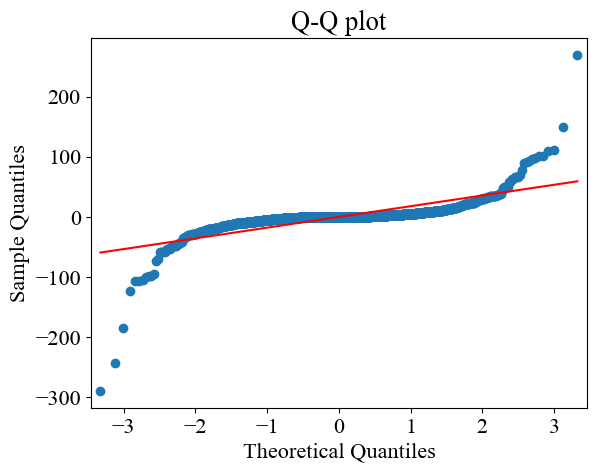

In [21]:
pplot = sm.ProbPlot(model_rlm_fe_2.resid)
fig = pplot.qqplot(line='s')
plt.title('Q-Q plot')
print(stats.normaltest(model_rlm_fe_2.resid))

In [22]:
model_bootstrap = utils.bootstrap_model(df,model=model_rlm_pool_1,param_names=reg_cols_baseline,n_bootstrap=1000)
model_bootstrap.bootstrap()
with open('bootstrap_rlm_pool_baseline.pkl', 'wb') as file:
    pickle.dump(model_bootstrap, file)

100%|██████████| 1000/1000 [00:24<00:00, 41.58it/s]


In [23]:
model_bootstrap = utils.bootstrap_model(df,model=model_rlm_pool_2,param_names=reg_cols_label,n_bootstrap=1000)
model_bootstrap.bootstrap()
with open('bootstrap_rlm_pool_label.pkl', 'wb') as file:
    pickle.dump(model_bootstrap, file)

100%|██████████| 1000/1000 [00:25<00:00, 39.04it/s]


In [26]:
model_bootstrap = utils.bootstrap_model(df,model=model_rlm_fe,param_names=reg_cols_baseline,n_bootstrap=1000,fe=True)
model_bootstrap.bootstrap()
with open('bootstrap_rlm_fe_baseline.pkl', 'wb') as file:
    pickle.dump(model_bootstrap, file)

100%|██████████| 1000/1000 [34:18<00:00,  2.06s/it]


In [27]:
model_bootstrap = utils.bootstrap_model(df,model=model_rlm_fe_2,param_names=reg_cols_label,n_bootstrap=1000,fe=True)
model_bootstrap.bootstrap()
with open('bootstrap_rlm_fe_label.pkl', 'wb') as file:
    pickle.dump(model_bootstrap, file)

100%|██████████| 1000/1000 [33:53<00:00,  2.03s/it] 


In [28]:
# save regression results
model_results = {
                 'rlm_pool_baseline':utils.get_reg_result(model_rlm_pool_1,reg_cols_baseline),
                 'rlm_pool_label':utils.get_reg_result(model_rlm_pool_2,reg_cols_label),
                 'rlm_fe_baseline':utils.get_reg_result(model_rlm_fe,reg_cols_baseline),
                 'rlm_fe_label':utils.get_reg_result(model_rlm_fe_2,reg_cols_label)
                 }

with open('model_reg_result_gm.json', "w") as f:
    json.dump(model_results, f)